# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
#     if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [4]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def sample_config(config, eta, N, no_colors, sites, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field
    if alpha==0:
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Case with zero field and no interaction, use an arbitray partition (avoid computing Bell polynomials)'''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
        partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs],subs]")
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field
    else:
        '''Randomly sample a color for each cluster'''
        for root in cluster_constraints:
            max_col = cluster_constraints[root]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            for site_str in uf.clusteronent(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites):
    '''Assign a color configuration chosen uniformly from the configurations clusteratible with eta'''
    # Brute force version
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [27]:
only_averages = False
prt = True
N, no_cols = 4, 16
gamma = 0    # strength of preference for low no. of cols
J = 2       # strength of preference for bonds
alpha = 0   # strength of preference for colors (field)

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)
for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
edge probabilities: [0.98168436 0.01831564]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[15 12 11  9]
 [16 11  1 13]
 [15  4  2 12]
 [15  7  4 14]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 11
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 1  1  1  1]
 [ 1  1  1  1]
 [ 0  1  1  1]
 [-1 -1 -1 -1]]

[[ 1  1  1 -1]
 [ 1  1  1 -1]
 [ 1  1  1 -1]
 [ 1  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [ 9 13 14 15]]
prob_k: [16, 3931920, 7980339360, 1850107896000, 1104

current no. cols (lambda): 8
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 1  1  0  1]
 [ 1  0  1  1]
 [ 0  0  0  1]
 [-1 -1 -1 -1]]

[[ 1  1  1 -1]
 [ 1  1  0 -1]
 [ 1  1  1 -1]
 [ 1  1  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 2 3 4]
 [5 6 3 3]
 [7 6 8 9]
 [7 6 8 8]]
prob_k: [16, 61200, 10164000, 339393600, 3643436160, 15256200960, 26637811200, 18681062400, 4151347200, 0, 0, 0, 0, 0, 0, 0]
prob_k: [2.32830644e-10 8.90577212e-07 1.47905666e-04 4.93882690e-03
 5.30189741e-02 2.22006943e-01 3.87631170e-01 2.71845236e-01
 6.04100525e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
exact number of colors to use in configuration:
7
partition_dict {(6, 0, 1): 84, (5, 2, 0): 378}
p

probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  1  0  1]
 [ 0  0  0  1]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 1  1  0 -1]
 [ 1  1  1 -1]
 [ 1  1  0 -1]
 [ 1  1  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 2 3 3]
 [1 4 3 5]
 [1 4 3 3]
 [1 4 3 3]]
prob_k: [16, 3600, 84000, 436800, 524160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prob_k: [1.52587891e-05 3.43322754e-03 8.01086426e-02 4.16564941e-01
 4.99877930e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
exact number of colors to use in configuration:
4
partit

partition_p: [1.0]
chosen partition:
(5,)
chosen partition:
[1, 1, 1, 1, 1]
colors for clusters:
[ 8  6  1 12  5]
config:
[[ 8  6  1  1]
 [ 8  1  1 12]
 [ 8  1  1  1]
 [ 5  1  1  1]]

-------------------- iter 32 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  1  0  1]
 [ 0  0  0  1]
 [ 1  0  0  0]
 [-1 -1 -1 -1]]

[[ 1  1  0 -1]
 [ 1  0  1 -1]
 [ 1  0  0 -1]
 [ 1  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 2 3 3]
 [1 3 3 4]
 [1 3 3 3]
 [5 3 3 3]]
prob_k: [16, 3600, 84000, 436800, 524160, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prob_k: [1.52587891e-05 3.43322754e-03 8.01086426e-02 4.16564941e-01
 4.998

prob_k: [0.0625 0.9375 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.    ]
exact number of colors to use in configuration:
2
partition_dict {(2,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(2,)
chosen partition:
[1, 1]
colors for clusters:
[5 4]
config:
[[5 5 5 5]
 [5 5 5 4]
 [5 5 5 5]
 [5 5 5 5]]

-------------------- iter 45 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  0  1]
 [ 0  0  1  0]
 [-1 -1 -1 -1]]

[[ 0  1  0 -1]
 [ 0  0  1 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 2

partition_dict {(3,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(3,)
chosen partition:
[1, 1, 1]
colors for clusters:
[14 10 12]
config:
[[14 14 14 14]
 [14 14 14 12]
 [14 14 14 14]
 [14 14 14 10]]

-------------------- iter 57 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0  1]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 0  0  1 -1]
 [ 0  0  0 -1]
 [ 0  0  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 3]
 [1 1 1 1]
 [1 1 1 2]]
prob_k: [16, 720, 3360, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prob_k: [0.00390625 0.17578125 0.8203125  0.         0.  


-------------------- iter 68 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
prob_k: [16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prob_k: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
exact number of colors to use in configuration:
1
partition_dict {(1,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(1,)
chosen partition:
[1]
colors for clusters:
[15]
config:
[[15 15 15 15]
 [15 15 15 1

partition_dict {(1,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(1,)
chosen partition:
[1]
colors for clusters:
[7]
config:
[[7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]]

-------------------- iter 78 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
prob_k: [16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prob_k: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
exact number of colors to use in 

probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
prob_k: [16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
prob_k: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
exact number of colors to use in configuration:
1
partition_dict {(1,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(1,)
chosen partition:
[1]
colors for clusters:
[9]
config:
[[9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]]

-------------------- iter 91 --------------------
probabilities for no. of colors (lambda): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 16
probabilities for edges: [0.98168436 0.01831564]
assigned bonds (eta_edges):
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]

## Full simulation

In [6]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [7]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nparam), np.zeros(nparam)
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_.png", format="png")
    
    plt.show()

## Gamma (lambda / total number of colors)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 1.]
Initial configuration
[[4 4]
 [1 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.6732673267326734 avg. sites per col: 1.6105610561056107
201 num. cols: 2.7064676616915424 avg. sites per col: 1.5804311774461028
301 num. cols: 2.691029900332226 avg. sites per col: 1.6024363233665528
401 num. cols: 2.71072319201995 avg. sites per col: 1.5968412302576906
501 num. cols: 2.720558882235529 avg. sites per col: 1.5874916833000723
601 num. cols: 2.7437603993344424 avg. sites per col: 1.5734886300610178
701 num. cols: 2.7446504992867333 avg. sites per col:

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 1.702970297029703 avg. sites per col: 2.6732673267326734
201 num. cols: 1.8756218905472637 avg. sites per col: 2.4278606965174108
301 num. cols: 1.717607973421927 avg. sites per col: 2.688815060908083
401 num. cols: 1.7007481296758105 avg. sites per col: 2.6982543640897743
501 num. cols: 1.7325349301397206 avg. sites per col: 2.6387225548902173
601 num. cols: 1.7903494176372712 avg. sites per col: 2.536882972823069
701 num. cols: 1.8330955777460771 avg. sites per col: 2.4555397051830674
801 num. cols: 1.7815230961298376 avg. sites per col: 2.5584685809404863
901 num. cols: 1.7291897891231964 avg. sites per col: 2.6526082130965554
1001 num. cols: 1.7072927072927073 avg. sites per col: 2.6959706959706935
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.7044776119402985 2.70116086235489
Final stds: 0.6110343980238973 1.0283562700375362
-------------------

801 num. cols: 1.0699126092384519 avg. sites per col: 3.8601747815230962
901 num. cols: 1.0865704772475027 avg. sites per col: 3.8268590455049947
1001 num. cols: 1.077922077922078 avg. sites per col: 3.844155844155844
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.0776119402985074 3.8447761194029852
Final stds: 0.2675599503318992 0.5351199006637984
------------------------------------------------------------------------------------------------------------------------

13  - param: 5.57
lambda probabilities: [9.96189520e-01 3.79596067e-03 1.44644339e-05 5.53272657e-08]
Initial configuration
[[1 1]
 [3 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.0 avg. sites per col: 4.0
201 num. cols: 1.0 avg. sites per col: 4.0
301 num. cols: 1.0 avg. sites per col: 4.0
401 num. cols: 1.0 avg. sites per col: 4.0
501 num. cols: 1.0 av

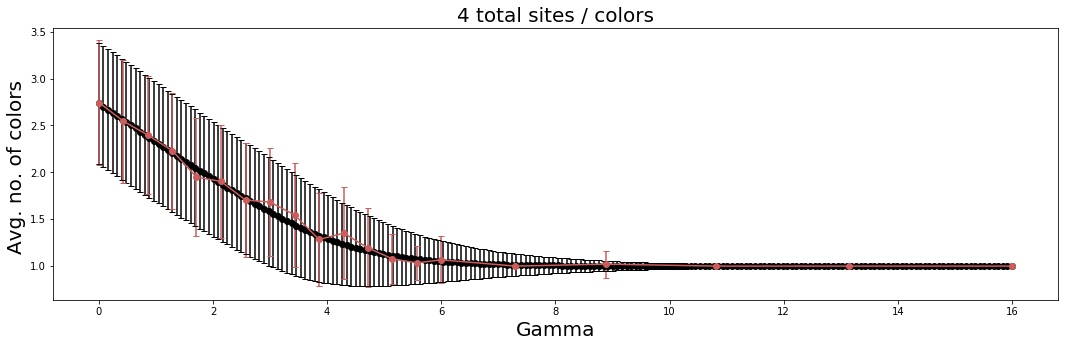

In [106]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (2, 4, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[1 9 6]
 [3 6 5]
 [5 6 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num. cols: 5.861386138613861 avg. sites per col: 1.5665134370579923
201 num. cols: 5.940298507462686 avg. sites per col: 1.550106609808103
301 num. cols: 5.960132890365449 avg. sites per col: 1.5442097769340302
401 num. cols: 5.975062344139651 avg. sites per col: 1.540639472746705
501 num. cols: 5.966067864271457 avg. sites per col: 1.5441402908468778
601 num. cols: 5.963394342762063 avg. sites per col: 1.5

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 1.8
101 num. cols: 4.1683168316831685 avg. sites per col: 2.3539603960396036
201 num. cols: 3.4378109452736316 avg. sites per col: 2.9679104477611937
301 num. cols: 3.495016611295681 avg. sites per col: 2.8619601328903634
401 num. cols: 3.5885286783042396 avg. sites per col: 2.744139650872815
501 num. cols: 3.662674650698603 avg. sites per col: 2.669076133447387
601 num. cols: 3.5607321131447587 avg. sites per col: 2.7748038982647922
701 num. cols: 3.5805991440798857 avg. sites per col: 2.736743427756262
801 num. cols: 3.606741573033708 avg. sites per col: 2.7010700909577268
901 num. cols: 3.645948945615982 avg. sites per col: 2.6646583161566526
1001 num. cols: 3.6003996003996006 avg. sites per col: 2.701006136720424
Final configuration:
[[1 2 3]
 [3 3 3]
 [3 3 3]]
Final averages: 3.5980099502487564 2.70219616204691
Final stds

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 2.1683168316831685 avg. sites per col: 4.2772277227722775
201 num. cols: 1.5870646766169154 avg. sites per col: 6.626865671641791
301 num. cols: 1.3953488372093024 avg. sites per col: 7.400332225913621
401 num. cols: 1.546134663341646 avg. sites per col: 6.677057356608479
501 num. cols: 1.6367265469061876 avg. sites per col: 6.24251497005988
601 num. cols: 1.838602329450915 avg. sites per col: 5.747920133111481
701 num. cols: 2.0042796005706136 avg. sites per col: 5.355920114122682
801 num. cols: 2.1048689138576777 avg. sites per col: 5.097378277153558
901 num. cols: 2.09322974472808 avg. sites per col: 5.031076581576027
1001 num. cols: 2.0839160839160837 avg. sites per col: 4.978021978021978
Final configuration:
[[1 2 2]
 [2 2 2]
 [2 2 2]]
Final averages: 2.083582089552239 4.976119402985074
Final stds: 0.69

801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[5 9 6]
 [1 5 5]
 [9 7 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg.

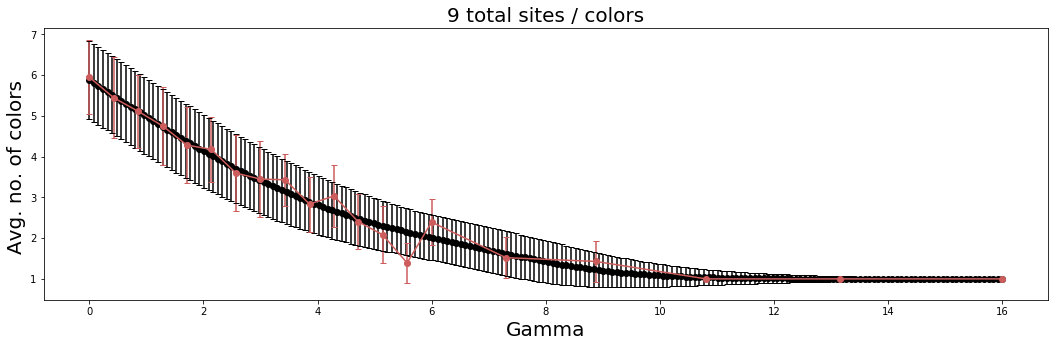

In [107]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (3, 9, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[14 14 13  9]
 [ 2 13 12  5]
 [ 8  5  9 13]
 [14  8 10  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.316831683168317 avg. sites per col: 1.5690861393831672
201 num. cols: 10.303482587064677 avg. sites per col: 1.572786086218921
301 num. cols: 10.305647840531561 avg. sites per col: 1.5729588978758398
401 num. cols: 10.314214463840399 avg. sites per col: 1.5724797231031697
501 num. cols: 10.30538922

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 7.03960396039604 avg. sites per col: 2.305201948766302
201 num. cols: 6.885572139303482 avg. sites per col: 2.3636105188344
301 num. cols: 7.1096345514950166 avg. sites per col: 2.3028232011620764
401 num. cols: 7.132169576059851 avg. sites per col: 2.2885815763621338
501 num. cols: 6.922155688622754 avg. sites per col: 2.394741829472376
601 num. cols: 6.936772046589018 avg. sites per col: 2.3824755758200062
701 num. cols: 6.950071326676177 avg. sites per col: 2.3706014701735096
801 num. cols: 6.990012484394507 avg. sites per col: 2.355906487741693
901 num. cols: 7.022197558268591 avg. sites per col: 2.340857761057536
1001 num. cols: 7.053946053946054 avg. sites per col: 2.329412002139266
Final configuration:
[[1 2 3 4]
 [5 6 7 7]
 [7 7 7 7]
 [7 7 7 7]]
Final averages: 7.051741293532339 2.329996195070813
Final stds: 1.11404844287443

501 num. cols: 4.894211576846307 avg. sites per col: 3.3832905617336846
601 num. cols: 4.835274542429285 avg. sites per col: 3.414024245305454
701 num. cols: 4.855920114122682 avg. sites per col: 3.3857754228652785
801 num. cols: 4.6716604244694135 avg. sites per col: 3.56566197015635
901 num. cols: 4.513873473917869 avg. sites per col: 3.7319591987738594
1001 num. cols: 4.63036963036963 avg. sites per col: 3.646391703534555
Final configuration:
[[1 2 3 4]
 [5 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 4.635820895522388 3.642492300402742
Final stds: 1.0616379196313583 0.8690994633015182
------------------------------------------------------------------------------------------------------------------------

11  - param: 4.71
lambda probabilities: [9.90995222e-01 8.92369156e-03 8.03558577e-05 7.23586626e-07
 6.51573663e-09 5.86727592e-11 5.28335146e-13 4.75754048e-15
 4.28405939e-17 3.85770019e-19 3.47377322e-21 3.12805552e-23
 2.81674443e-25 2.53641571e-27 2.28398593e-29 2.07536675e-

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.0 avg. sites per col: 8.0
401 num. cols: 2.0 avg. sites per col: 8.0
501 num. cols: 2.0 avg. sites per col: 8.0
601 num. cols: 2.0 avg. sites per col: 8.0
701 num. cols: 2.0 avg. sites per col: 8.0
801 num. cols: 2.0 avg. sites per col: 8.0
901 num. cols: 2.0 avg. sites per col: 8.0
1001 num. cols: 2.042957042957043 avg. sites per col: 7.8854478854478725
Final configuration:
[[1 2 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
Final averages: 2.0467661691542287 7.875290215588709
Final stds: 0.21113761999432248 0.5630336533181933
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-01 2.01961171e-05 4.07891382

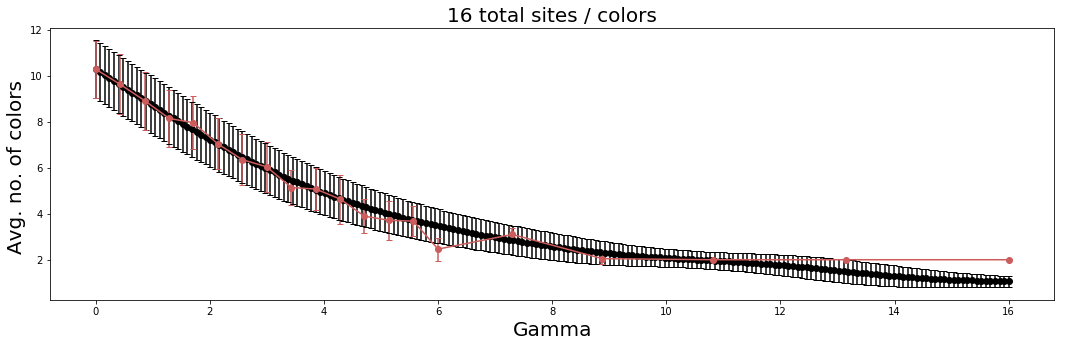

In [108]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (4, 16, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[ 8 10  2 22 16]
 [ 8  4 21  7 20]
 [ 3 10  1 14 10]
 [ 4  1 21 12 19]
 [17 15  6  9 15]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 1.6666666666666667
101 num. cols: 16.128712871287128 avg. sites per col: 1.563028442894641
201 num. cols: 16.104477611940297 avg. sites per col: 1.5684146801441528
301 num. cols: 16.023255813953487 avg. sites per col: 1.57

401 num. cols: 12.094763092269327 avg. sites per col: 2.1024804962937567
501 num. cols: 12.165668662674651 avg. sites per col: 2.0869613228278263
601 num. cols: 12.104825291181365 avg. sites per col: 2.0970035627591614
701 num. cols: 11.837375178316691 avg. sites per col: 2.149238455827778
801 num. cols: 11.957553058676654 avg. sites per col: 2.1278234909403597
901 num. cols: 11.81354051054384 avg. sites per col: 2.155219952785558
1001 num. cols: 11.917082917082917 avg. sites per col: 2.135114333522541
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]]
Final averages: 11.917412935323384 2.13490823998945
Final stds: 1.5683896338011059 0.2858567046471276
------------------------------------------------------------------------------------------------------------------------

5  - param: 2.14
lambda probabilities: [8.82345157e-01 1.03812181e-01 1.22140059e-02 1.43703694e-03
 1.69074356e-04 1.98924168e-05 2.34043917e-06 2.75364004

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 8.257425742574258 avg. sites per col: 3.0376787678767876
201 num. cols: 8.228855721393035 avg. sites per col: 3.049040511727078
301 num. cols: 8.813953488372093 avg. sites per col: 2.8739468357408597
401 num. cols: 8.765586034912719 avg. sites per col: 2.8847733383269625
501 num. cols: 8.47305389221557 avg. sites per col: 2.997771246274258
601 num. cols: 8.194675540765392 avg. sites per col: 3.113277575632015
701 num. cols: 8.049928673323823 avg. sites per col: 3.167171135252471
801 num. cols: 8.00374531835206 avg. sites per col: 3.1797411736550467
901 num. cols: 7.739178690344062 avg. sites per col: 3.3343996766582884
1001 num. cols: 7.62037962037962 avg. sites per col: 3.4037970576432177
Final configuration:
[[1 2 3 4 5]
 [6 7 8 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 7.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.107231920199501 avg. sites per col: 6.115960099750623
501 num. cols: 4.285429141716567 avg. sites per col: 5.893213572854291
601 num. cols: 4.404326123128119 avg. sites per col: 5.74459234608985
701 num. cols: 4.489300998573467 avg. sites per col: 5.638373751783167
801 num. cols: 4.5530586766541825 avg. sites per col: 5.558676654182272
901 num. cols: 4.602663706992231 avg. sites per col: 5.496670366259711
1001 num. cols: 4.642357642357642 avg. sites per col: 5.447052947052947
Final configuration:
[[1 2 3 4 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
Final averages: 4.643781094527363 5.445273631840796
Final stds: 0.4788809840205742 0.5986012300257177
--------------

801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[1 2 3 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



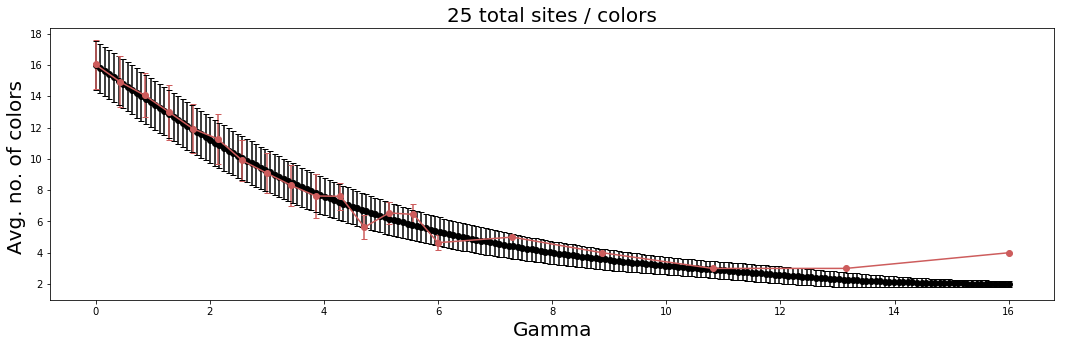

In [109]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (5, 25, gammas=gammas, J=0, alpha=0)

## J (edges / neighbor interaction)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.34 2.74 3.2  3.75 4.38 5.13 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[3 1]
 [2 3]]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.6732673267326734 avg. sites per col: 1.610561056105611
Final configuration:
[[1 3]
 [3 1]]
Final averages: 2.676190476190476 1.606349206349207
Final stds: 0.6689755934794646 0.49072013248418495
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[1 4]
 [4 4]]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.712871287128713 avg. sites per col: 1.5940594059405944
Final configuration:
[[3 3]
 [3 1]]


1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.1485148514851484 avg. sites per col: 3.729372937293729
Final configuration:
[[2 2]
 [2 2]]
Final averages: 1.1428571428571428 3.7396825396825393
Final stds: 0.40067969462785963 0.6976619341423337
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[1 1]
 [3 3]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.099009900990099 avg. sites per col: 3.801980198019802
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.0952380952380953 3.8095238095238093
Final stds: 0.29354352395090366 0.5870870479018073
------------------------------------------------------------------------------------------------------------------------

18  - param: 1.8
edge probabilities: [0.97267628 0.02732372]
Initial configuration
[[1 1]
 [3 2]]
equilibration step: 0
1 num. co

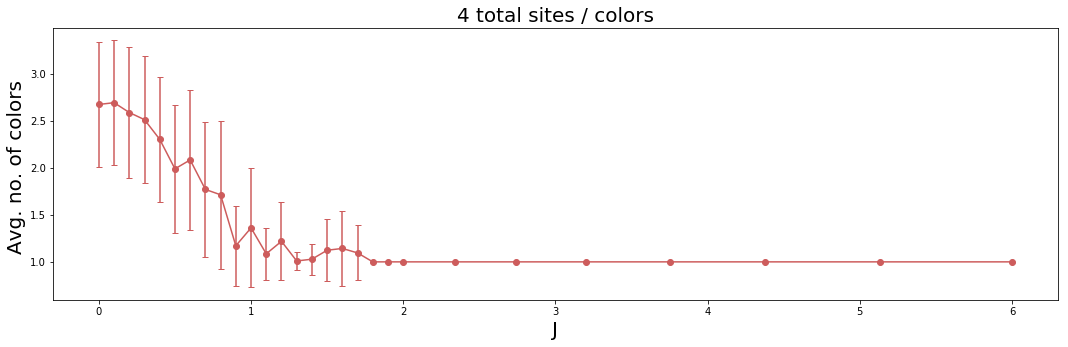

In [23]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=8)).round(decimals=2)
experiment_full_interaction (2, 4, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[2 2]
 [2 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.772277227722772 avg. sites per col: 1.5445544554455448
201 num. cols: 2.746268656716418 avg. sites per col: 1.5422885572139307
301 num. cols: 2.740863787375415 avg. sites per col: 1.5470653377630088
401 num. cols: 2.7531172069825436 avg. sites per col: 1.5411471321695767
501 num. cols: 2.7664670658682633 avg. sites per col: 1.5382568196939501
601 num. cols: 2.7570715474209653 avg. sites per col: 1.5452024403771567
701 num. cols: 2.760342368045649 avg. sites per col: 1.545411

201 num. cols: 1.9751243781094527 avg. sites per col: 2.437810945273629
301 num. cols: 1.9667774086378738 avg. sites per col: 2.4518272425249172
401 num. cols: 1.9201995012468829 avg. sites per col: 2.522859517871989
501 num. cols: 1.9620758483033933 avg. sites per col: 2.455755156353956
601 num. cols: 1.9317803660565724 avg. sites per col: 2.493067110371598
701 num. cols: 1.9144079885877319 avg. sites per col: 2.5016642891107885
801 num. cols: 1.8888888888888888 avg. sites per col: 2.543487307532245
901 num. cols: 1.904550499445061 avg. sites per col: 2.5301516833148323
1001 num. cols: 1.949050949050949 avg. sites per col: 2.465534465534467
Final configuration:
[[4 3]
 [4 4]]
Final averages: 1.9512437810945273 2.46235489220564
Final stds: 0.7896160319321099 1.0851238852831242
------------------------------------------------------------------------------------------------------------------------

7  - param: 0.7
edge probabilities: [0.75340304 0.24659696]
Initial configuration
[[3 3]
 

1001 num. cols: 1.1398601398601398 avg. sites per col: 3.7375957375957385
Final configuration:
[[3 3]
 [3 3]]
Final averages: 1.1393034825870647 3.7386401326699845
Final stds: 0.38179663316004925 0.6909463690244608
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[4 2]
 [2 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.1386138613861385 avg. sites per col: 3.722772277227723
201 num. cols: 1.1194029850746268 avg. sites per col: 3.7678275290215586
301 num. cols: 1.0830564784053156 avg. sites per col: 3.838316722037652
401 num. cols: 1.084788029925187 avg. sites per col: 3.8370739817123853
501 num. cols: 1.0818363273453093 avg. sites per col: 3.8416500332667995
601 num. cols: 

201 num. cols: 1.0099502487562189 avg. sites per col: 3.9800995024875623
301 num. cols: 1.0066445182724253 avg. sites per col: 3.9867109634551494
401 num. cols: 1.0049875311720697 avg. sites per col: 3.9900249376558605
501 num. cols: 1.003992015968064 avg. sites per col: 3.992015968063872
601 num. cols: 1.0033277870216306 avg. sites per col: 3.9933444259567388
701 num. cols: 1.0028530670470757 avg. sites per col: 3.9942938659058487
801 num. cols: 1.0024968789013733 avg. sites per col: 3.9950062421972534
901 num. cols: 1.002219755826859 avg. sites per col: 3.995560488346282
1001 num. cols: 1.003996003996004 avg. sites per col: 3.992007992007992
Final configuration:
[[2 2]
 [2 2]]
Final averages: 1.0039800995024875 3.992039800995025
Final stds: 0.06296235629674178 0.12592471259348356
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168436 0.01831564]
Initial configuration
[[

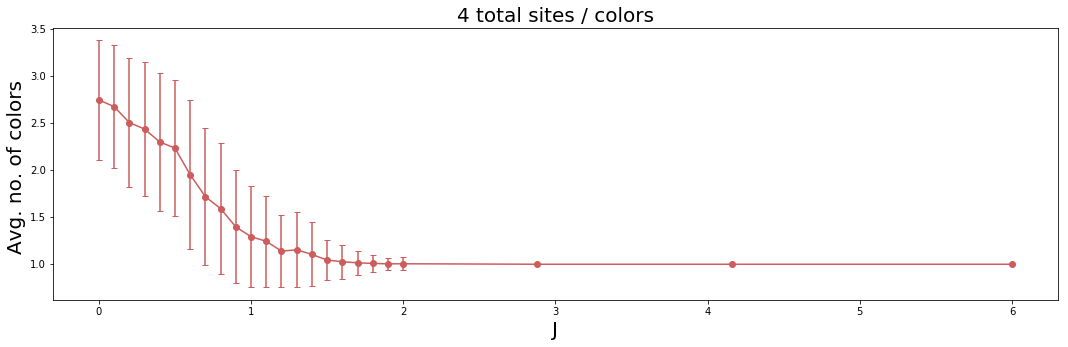

In [29]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (2, 4, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.34 2.74 3.2  3.75 4.38 5.13 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[1 6 8]
 [5 5 6]
 [2 2 8]]
equilibration step: 0
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num. cols: 6.0594059405940595 avg. sites per col: 1.5299151343705806
Final configuration:
[[8 7 5]
 [5 2 8]
 [4 1 9]]
Final averages: 6.0476190476190474 1.5324489795918375
Final stds: 0.989284997994125 0.28274138456477504
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[1 1 2]
 [2 3 7]
 [8 8 7]]
equilibration step: 0
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num

1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.1485148514851484 avg. sites per col: 8.361386138613861
Final configuration:
[[4 4 4]
 [4 4 4]
 [4 4 4]]
Final averages: 1.1428571428571428 8.385714285714286
Final stds: 0.3761603363453619 1.5724671892362303
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[5 6 4]
 [5 8 7]
 [2 4 7]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0297029702970297 avg. sites per col: 8.866336633663366
Final configuration:
[[3 3 3]
 [3 3 3]
 [3 3 3]]
Final averages: 1.0285714285714285 8.871428571428572
Final stds: 0.1665986255670086 0.7496938150515386
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[3 3 8]
 [3

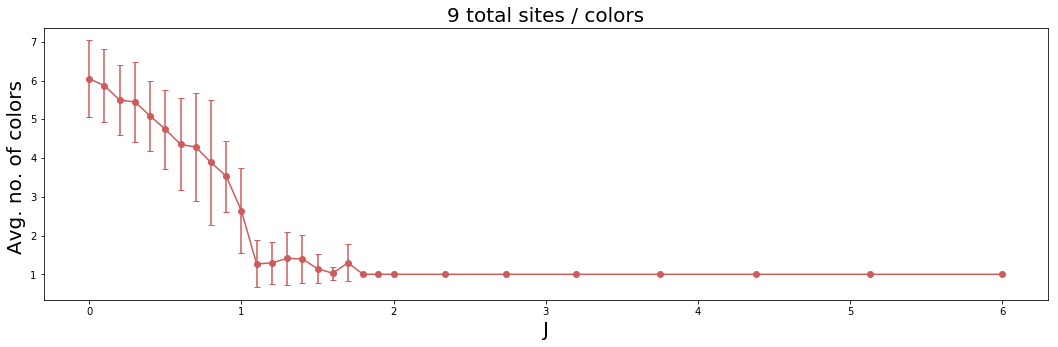

In [24]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=8)).round(decimals=2)
experiment_full_interaction (3, 9, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[9 8 5]
 [6 8 1]
 [4 1 9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 1.5
101 num. cols: 5.782178217821782 avg. sites per col: 1.6144625176803395
201 num. cols: 5.825870646766169 avg. sites per col: 1.5990405117270794
301 num. cols: 5.813953488372093 avg. sites per col: 1.6050783103939257
401 num. cols: 5.837905236907731 avg. sites per col: 1.5959476309226934
501 num. cols: 5.844311377245509 avg. sites per col: 1.5907185628742506
601 num. cols: 5.831946755407654 avg. sites per col: 1.5922747801283557
701 num. cols: 5.8445

equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 1.8
101 num. cols: 4.7227722772277225 avg. sites per col: 2.040487977369166
201 num. cols: 4.646766169154229 avg. sites per col: 2.0985607675906204
301 num. cols: 4.528239202657807 avg. sites per col: 2.137909349786426
401 num. cols: 4.448877805486284 avg. sites per col: 2.20487174919843
501 num. cols: 4.560878243512974 avg. sites per col: 2.1435414884516635
601 num. cols: 4.570715474209651 avg. sites per col: 2.1253506061326295
701 num. cols: 4.634807417974322 avg. sites per col: 2.092021601793348
801 num. cols: 4.647940074906367 avg. sites per col: 2.0843231674692255
901 num. cols: 4.685904550499445 avg. sites per col: 2.06470588235293
1001 num. cols: 4.683316683316684 avg. sites per col: 2.061424289995707
Final configuration:
[[9 3 3]
 [6 3 3]
 [6 6 7]]
Final averages: 4.678606965174129 2.0636673773987093
Final stds: 1.1290774862256954 0.6540868252881806
-------------------------------------------

601 num. cols: 1.4658901830282862 avg. sites per col: 7.262895174708818
701 num. cols: 1.4679029957203995 avg. sites per col: 7.284308131241084
801 num. cols: 1.488139825218477 avg. sites per col: 7.221722846441948
901 num. cols: 1.5271920088790234 avg. sites per col: 7.0739733629300785
1001 num. cols: 1.5164835164835164 avg. sites per col: 7.093306693306694
Final configuration:
[[2 2 2]
 [2 2 2]
 [6 2 2]]
Final averages: 1.518407960199005 7.082985074626866
Final stds: 0.7576537840293864 2.4595886168130514
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[8 6 2]
 [7 1 4]
 [9 3 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.4752475247524752 avg. sites per col: 7.06930693069

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.00990099009901 avg. sites per col: 8.955445544554456
201 num. cols: 1.0049751243781095 avg. sites per col: 8.977611940298507
301 num. cols: 1.0033222591362125 avg. sites per col: 8.985049833887043
401 num. cols: 1.0024937655860349 avg. sites per col: 8.988778054862843
501 num. cols: 1.001996007984032 avg. sites per col: 8.991017964071856
601 num. cols: 1.0016638935108153 avg. sites per col: 8.99251247920133
701 num. cols: 1.0328102710413696 avg. sites per col: 8.852353780313837
801 num. cols: 1.0287141073657928 avg. sites per col: 8.870786516853933
901 num. cols: 1.025527192008879 avg. sites per col: 8.885127635960044
1001 num. cols: 1.022977022977023 avg. sites per col: 8.896603396603396
Final configuration:
[[2 2 2]
 [2 2 2]
 [2 2 2]]
Final averages: 1.0228855721393035 8.897014925373135
Final stds: 0.149

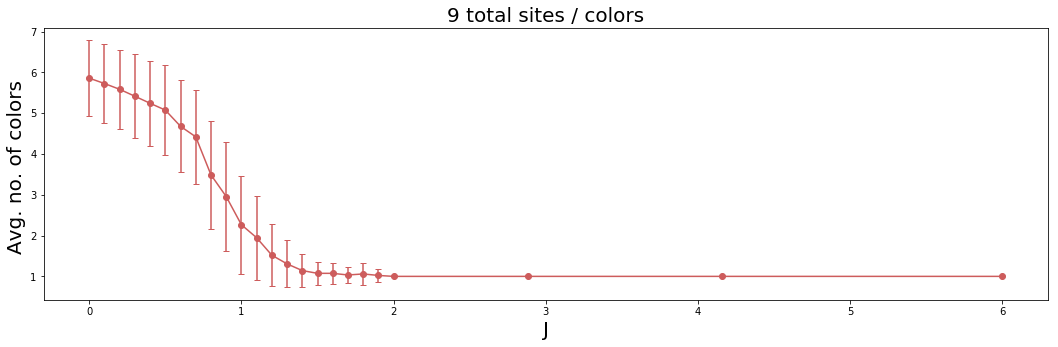

In [30]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (3, 9, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.34 2.74 3.2  3.75 4.38 5.13 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[11 12 11  9]
 [ 2  9 14 14]
 [ 9  5 13  7]
 [12 11 12  2]]
equilibration step: 0
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.376237623762377 avg. sites per col: 1.5641902651803627
Final configuration:
[[10 15 16 13]
 [11 16  8 12]
 [16 12  2 10]
 [13  6 13  6]]
Final averages: 10.361904761904762 1.5658622858622846
Final stds: 1.2276482319483442 0.18659860880799833
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[1

101 num. cols: 1.8514851485148516 avg. sites per col: 9.768976897689768
Final configuration:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
Final averages: 1.819047619047619 10.006349206349205
Final stds: 0.5981073702136221 3.8736611484317702
------------------------------------------------------------------------------------------------------------------------

14  - param: 1.4
edge probabilities: [0.93918994 0.06081006]
Initial configuration
[[ 1 13  5  9]
 [13  9  3  4]
 [13 13  7  7]
 [ 4 16 14  4]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
Initial configuration
[[12 10  5 14]
 [13 15  9  1]
 [ 2  5  7 10]
 [14 15  8 10]]
equilibr

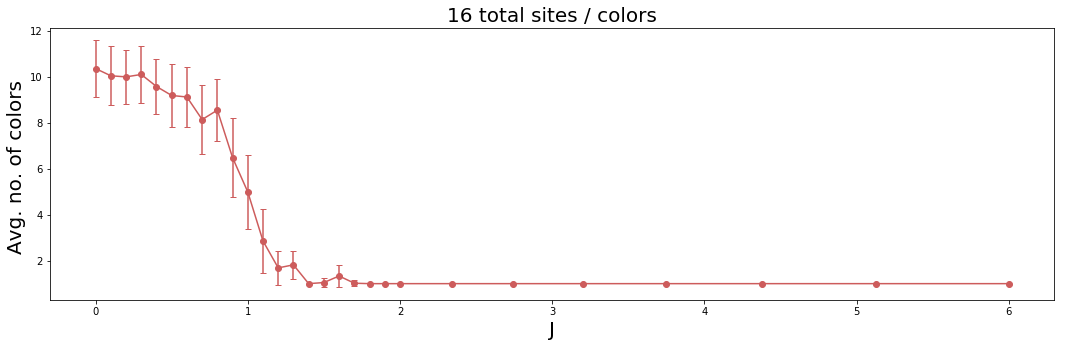

In [25]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=8)).round(decimals=2)
experiment_full_interaction (4, 16, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[13  6  9  7]
 [ 9  6  5  2]
 [ 7 12  3 12]
 [12 15  5 11]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.257425742574258 avg. sites per col: 1.5894952132575884
201 num. cols: 10.228855721393035 avg. sites per col: 1.5937641131670974
301 num. cols: 10.212624584717608 avg. sites per col: 1.5932668291472274
401 num. cols: 10.239401496259351 avg. sites per col: 1.5885016064567252
501 num. cols: 10.241516966067865 avg. sites per col: 1.58737682809540

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
101 num. cols: 8.673267326732674 avg. sites per col: 1.8921492149214905
201 num. cols: 8.91044776119403 avg. sites per col: 1.8362875377800743
301 num. cols: 8.787375415282392 avg. sites per col: 1.8659226340289474
401 num. cols: 8.775561097256858 avg. sites per col: 1.8725696581058253
501 num. cols: 8.7624750499002 avg. sites per col: 1.8779191976796876
601 num. cols: 8.743760399334443 avg. sites per col: 1.8830677180094932
701 num. cols: 8.78601997146933 avg. sites per col: 1.8735793292141463
801 num. cols: 8.852684144818976 avg. sites per col: 1.8582272215231088
901 num. cols: 8.821309655937847 avg. sites per col: 1.8662850529665236
1001 num. cols: 8.836163836163836 avg. sites per col: 1.8618128236509899
Final configuration:
[[12  7 14  6]
 [ 5  7  7  6]
 [12  3 11  3]
 [12  3  8 11]]
Final averages: 8.83

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.6336633663366336 avg. sites per col: 10.983498349834983
201 num. cols: 1.9104477611940298 avg. sites per col: 9.59867330016583
301 num. cols: 1.7906976744186047 avg. sites per col: 10.387596899224798
401 num. cols: 1.6783042394014962 avg. sites per col: 11.175394846217786
501 num. cols: 2.063872255489022 avg. sites per col: 10.008022051135802
601 num. cols: 1.923460898502496 avg. sites per col: 10.76542270818475
701 num. cols: 1.9400855920114122 avg. sites per col: 10.649004823041887
801 num. cols: 2.0724094881398254 avg. sites per col: 10.24276796861064
901 num. cols: 1.9966703662597114 avg. sites per col: 10.55914592251993
1001 num. cols: 2.097902097902098 avg. sites per col: 10.1114123971267
Final configuration:
[[ 8  5  8  7]
 [ 8  8  8  8]
 [ 8  8  8  8]
 [16  8  8  8]]
Final averages: 2.1044776119402986 10.088415067519561
F

401 num. cols: 1.0498753117206983 avg. sites per col: 15.600997506234414
501 num. cols: 1.0399201596806387 avg. sites per col: 15.68063872255489
601 num. cols: 1.0332778702163061 avg. sites per col: 15.733777038269551
701 num. cols: 1.028530670470756 avg. sites per col: 15.771754636233952
801 num. cols: 1.024968789013733 avg. sites per col: 15.800249687890137
901 num. cols: 1.04661487236404 avg. sites per col: 15.633000369959305
1001 num. cols: 1.0419580419580419 avg. sites per col: 15.66966366966367
Final configuration:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
Final averages: 1.0417910447761194 15.670978441127696
Final stds: 0.20502342086669895 1.597566967163238
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[14 10 15  4]
 [ 3  5  6  3]
 [ 2  3  1 13]
 [10 12 13  3]]
equilibration step: 0
equilibration step: 1000
equilibrati

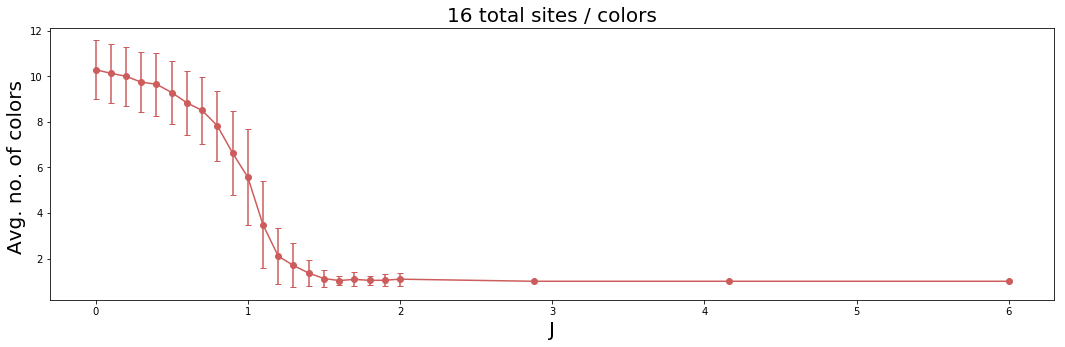

In [31]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (4, 16, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.34 2.74 3.2  3.75 4.38 5.13 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[21 17 18  7 24]
 [11 18 20  9 23]
 [24  3  8  1 13]
 [ 9 23 24  9  6]
 [10  8 21 25  4]]
equilibration step: 0
1 num. cols: 18.0 avg. sites per col: 1.3888888888888888
101 num. cols: 16.03960396039604 avg. sites per col: 1.5733217516372802
Final configuration:
[[ 8 13  8 23  1]
 [13 21  4 20  3]
 [14 22 25  4 17]
 [25 18  4 18 24]
 [17 25  6  9  1]]
Final averages: 16.038095238095238 1.5730262077840578
Final stds: 1.5301653164581959 0.15028438233520486
--------------------------------------------------------------------------------------------

1 num. cols: 6.0 avg. sites per col: 4.166666666666667
101 num. cols: 6.6138613861386135 avg. sites per col: 3.9542079207920775
Final configuration:
[[15 15  5 25 23]
 [15 16 16 25 13]
 [19 16 16 16 13]
 [16 16 16 16 16]
 [17 17 12 16 16]]
Final averages: 6.628571428571429 3.9470899470899456
Final stds: 1.3540566412654613 0.8875493812436696
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[12 20 19 10 15]
 [ 3  7 23  8  3]
 [18 18 19 16  1]
 [14 21 25 13  9]
 [15  7 10  1 19]]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 2.4752475247524752 avg. sites per col: 11.344884488448852
Final configuration:
[[9 9 7 7 7]
 [3 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 2.4761904761904763 11.309523809523814
Final stds: 0.7818809810199538 4.349720453915502
----------------------------------

101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

27  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial configuration
[[20  6 25 17 20]
 [19  5 12 24  7]
 [ 9  5 19 10 10]
 [ 6  5 23 10 16]
 [15  1  4  6  6]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



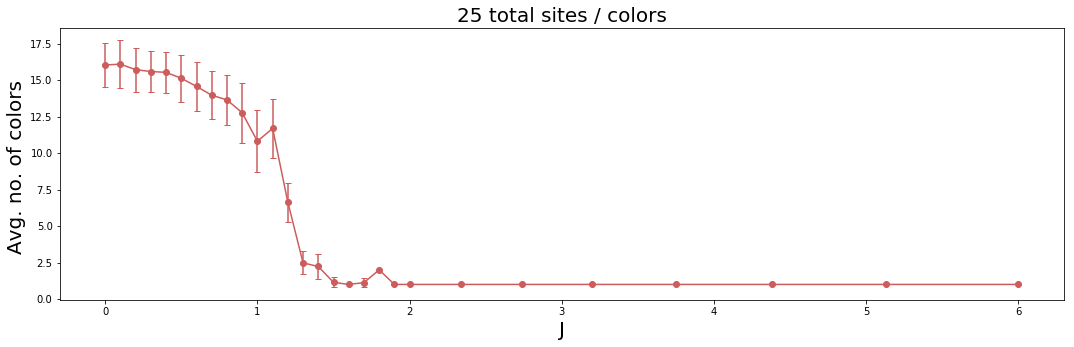

In [26]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=8)).round(decimals=2)
experiment_full_interaction (5, 25, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[19 22  8  3 12]
 [ 3 16 25 25 18]
 [10 18 23 22  7]
 [ 3 24 13  6 25]
 [22  6 14 24 19]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 15.841584158415841 avg. sites per col: 1.5936414049325187
201 num. cols: 15.965174129353233 avg. sites per col: 1.5822768647124048
301 num. cols: 15.976744186046512 avg. sites per col: 1.5810580597558774
401 num. cols: 15.88778054862843 avg. sites per col: 1.59

501 num. cols: 15.029940119760479 avg. sites per col: 1.6853936463730055
601 num. cols: 14.958402662229616 avg. sites per col: 1.694641100285333
701 num. cols: 14.968616262482168 avg. sites per col: 1.693977578137151
801 num. cols: 14.935081148564295 avg. sites per col: 1.6980643594543907
901 num. cols: 14.937846836847946 avg. sites per col: 1.6977729128948724
1001 num. cols: 14.918081918081919 avg. sites per col: 1.7008015558004674
Final configuration:
[[ 8  8  9 22 10]
 [ 4  8  3 13  8]
 [18 21  4  2 24]
 [ 4 16 17 24 24]
 [15  6  3 17 20]]
Final averages: 14.917412935323384 1.7008171817041573
Final stds: 1.7704442688450852 0.21350925635242823
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[15 11 24  6 21]
 [21 13 20 25  6]
 [15  3 16  3 17]
 [ 7  3 13  8 15]
 [17  2  9 20 14]]
equilibration step: 0
equilibration step: 1000
equi

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 4.910891089108911 avg. sites per col: 5.519801980198016
201 num. cols: 5.666666666666667 avg. sites per col: 4.787570086077542
301 num. cols: 5.760797342192691 avg. sites per col: 4.761772926224756
401 num. cols: 5.453865336658354 avg. sites per col: 5.359574098663875
501 num. cols: 4.860279441117765 avg. sites per col: 6.441329102257253
601 num. cols: 4.324459234608985 avg. sites per col: 8.361102407483447
701 num. cols: 4.185449358059914 avg. sites per col: 8.78255373173348
801 num. cols: 4.0 avg. sites per col: 8.93142342814626
901 num. cols: 4.013318534961154 avg. sites per col: 8.904704248766386
1001 num. cols: 4.341658341658341 avg. sites per col: 8.380455222987669
Final configuration:
[[13  7  7 14 24]
 [25 15 15 15 10]
 [10 10 15 15 15]
 [10 10 15 15 15]
 [19 17 15 15 15]]
Final averages: 4.353233830845771 8.36111739283379
Final stds: 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.8217821782178218 avg. sites per col: 16.79042904290427
201 num. cols: 1.4825870646766168 avg. sites per col: 20.004145936981747
301 num. cols: 1.3787375415282392 avg. sites per col: 20.9579180509413
401 num. cols: 1.28428927680798 avg. sites per col: 21.965918536990852
501 num. cols: 1.375249500998004 avg. sites per col: 21.074517631403882
601 num. cols: 1.377703826955075 avg. sites per col: 20.971991125901297
701 num. cols: 1.3366619115549216 avg. sites per col: 21.386115073704254
801 num. cols: 1.2946317103620475 avg. sites per col: 21.83728672492719
901 num. cols: 1.2619311875693673 avg. sites per col: 22.188309285978555
1001 num. cols: 1.2357642357642358 avg. sites per col: 22.469197469197482
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]

701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



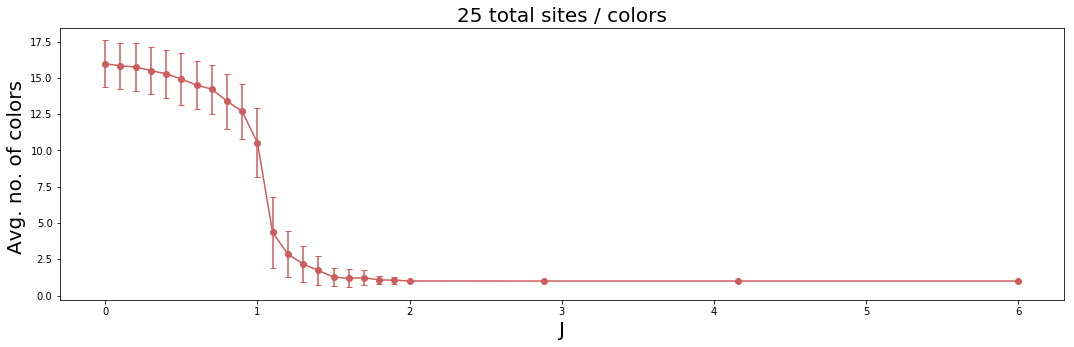

In [32]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (5, 25, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[ 5 10  8 16 10]
 [10  8 19 15  8]
 [10  3 14 18 17]
 [ 9 18 20 13  2]
 [ 2  7 18  5 10]]
equilibration step: 0
1 num. cols: 16.0 avg. sites per col: 1.5625
101 num. cols: 15.742574257425742 avg. sites per col: 1.6075407829116863
Final configuration:
[[ 6  7 14 10 16]
 [ 7 14 25 19 21]
 [ 6  5 12 13 12]
 [11 17 13  1  8]
 [22  9 25 17 16]]
Final averages: 15.8 1.6015454539890623
Final stds: 1.731500862862978 0.17788490121933204
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.4

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 7.3
edge probabilities: [9.99999544e-01 4.56352637e-07]
Initial configuration
[[ 4  6 21  7 18]
 [11  5  7 13  7]
 [23 22  9  9  5]
 [11  4 19  1 14]
 [20 11 13 14 24]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 8.88
edge probabilities: [9.99999981e-01 1.93610988e-08]
Initial configuration

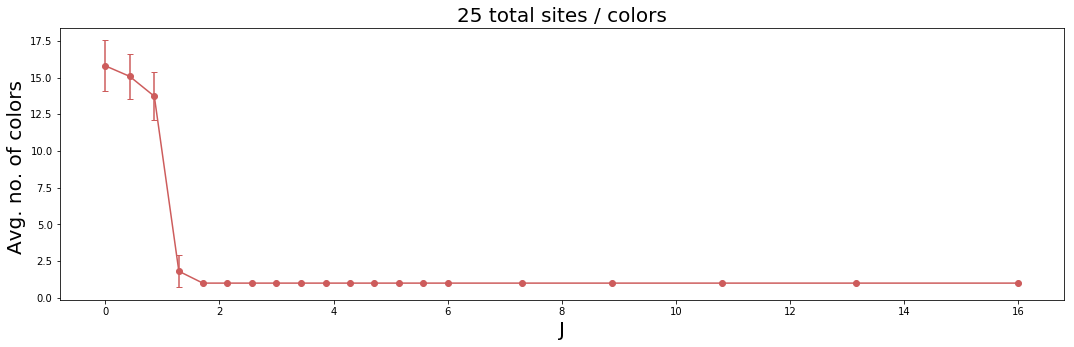

In [15]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 6, num=nJ-6, endpoint=False)
Js = np.append(Js, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (5, 25, Js=Js, gamma=0, alpha=0)